# Exp4:  Bert
使用实验三的数据集，在预训练的Bert模型上微调参数。使用微调后的Bert模型做文本分类，并与实验三的RNN模型进行对比分析

https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [1]:
import time
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, LongformerModel, LongformerTokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 20211206
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# device = torch.device("mps")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. 读取数据
由于内存不够，所以随机采样1w条数据来跑。

In [2]:
data_path = "./train.csv"
df = pd.read_csv(data_path)
# df = df.drop_duplicates(subset=['label', 'review'], keep='first')
# df = df.drop_duplicates(subset=['review'], keep=False).reset_index(drop=True)
df = df.sample(10000)
df

,id,review,label
11306,id_11306,罪犯叶岩，男，1989年xx月xx日生，汉族，河北省衡水市人，初中毕业，现在吉林省长春净月监...,9
30753,id_30753,罪犯龙信思，男，1972年xx月xx日出生，汉族，广东省吴川市人，大专文化，原住广东省吴川市...,9
4800,id_4800,罪犯李电钧，女，1965年xx月xx日出生，汉族，四川省岳池县人，小学文化，现在四川省凉山监...,6
30907,id_30907,罪犯朱言，曾用名朱晓光，男，1983年xx月xx日出生，蒙古族，初中文化，现在内蒙古自治区通...,1
5309,id_5309,罪犯陈被善，男，1990年xx月xx日出生，汉族，广西壮族自治区柳州市人，中专文化，原住广西...,6
...,...,...,...
34992,id_34992,罪犯戴信，男，1991年xx月xx日出生，汉族江西省分宜县人。现在江西省赣江监狱服刑，认定戴...,8
165,id_165,罪犯杜若，男，1976年xx月xx日生，汉族，吉林省长春市人，初级中学教育，现在吉林省长春兴...,20
39865,id_39865,罪犯李金炎，男，1992年xx月xx日出生，汉族，出生地四川省绵阳市，小学文化，现在辽宁省康...,7
33878,id_33878,罪犯郝凯泽，男，1963年xx月xx日出生，汉族，河南省禹州市人，初中文化，现在辽宁省瓦房店...,7


## 2. 查看长度分布 

In [3]:
PRE_TRAINED_MODEL_NAME = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
longformer_model = LongformerModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [4]:
token_lens = []
for txt in df.review:
    tokens = tokenizer.encode(txt, max_length=2000)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [5]:
label_len = []
for label in df.label:
    label_len.append(label)

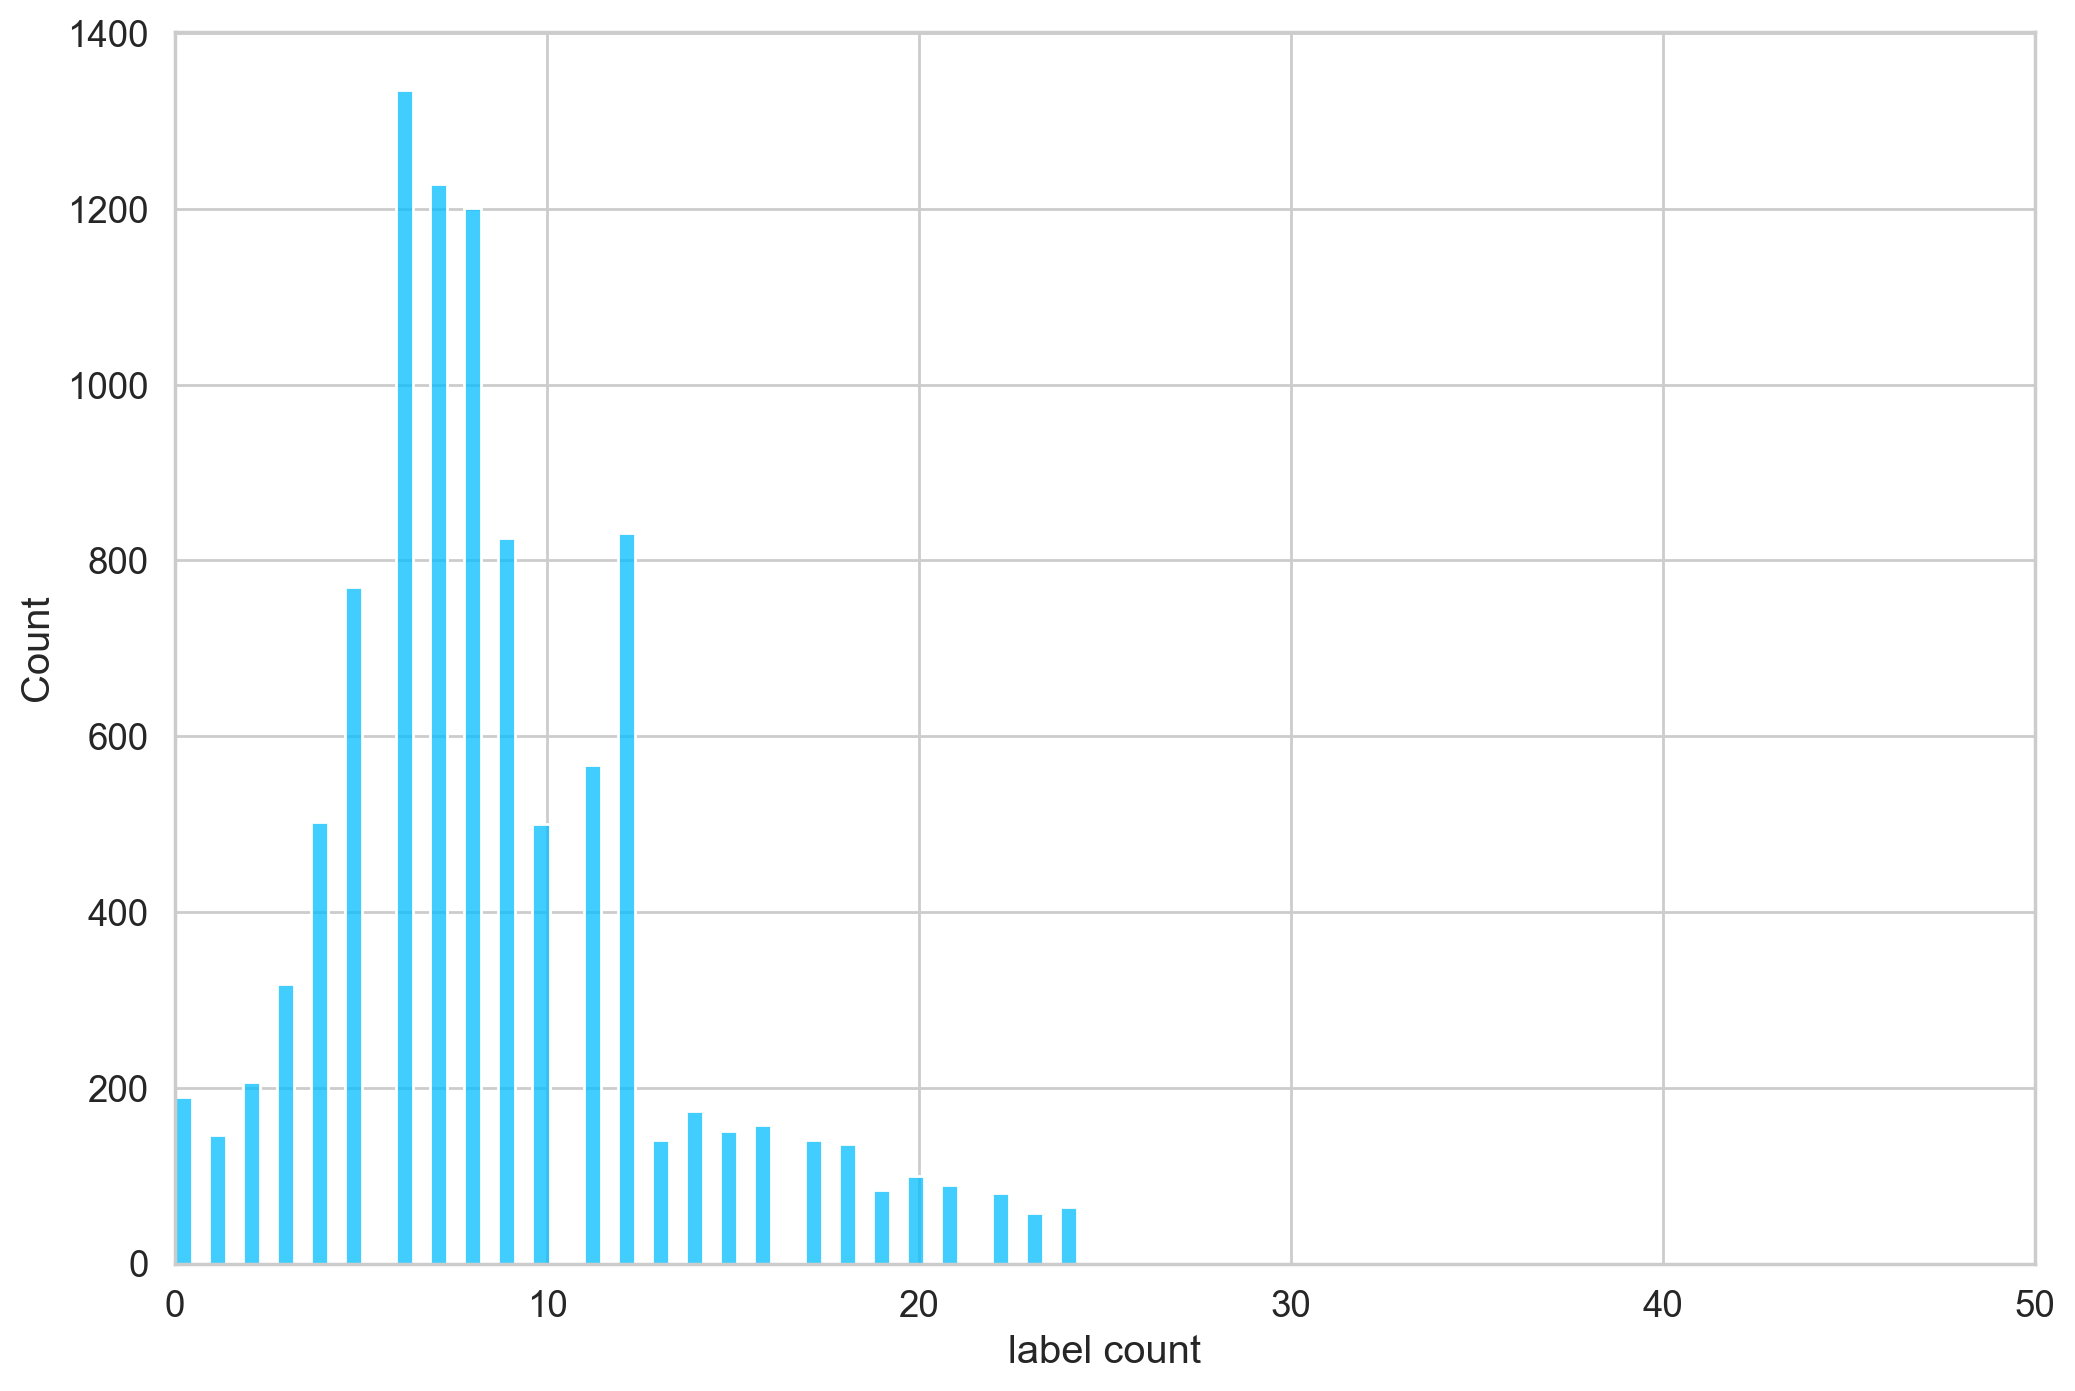

In [6]:
sns.histplot(label_len)
plt.xlim([0, 50]);
plt.xlabel('label count');

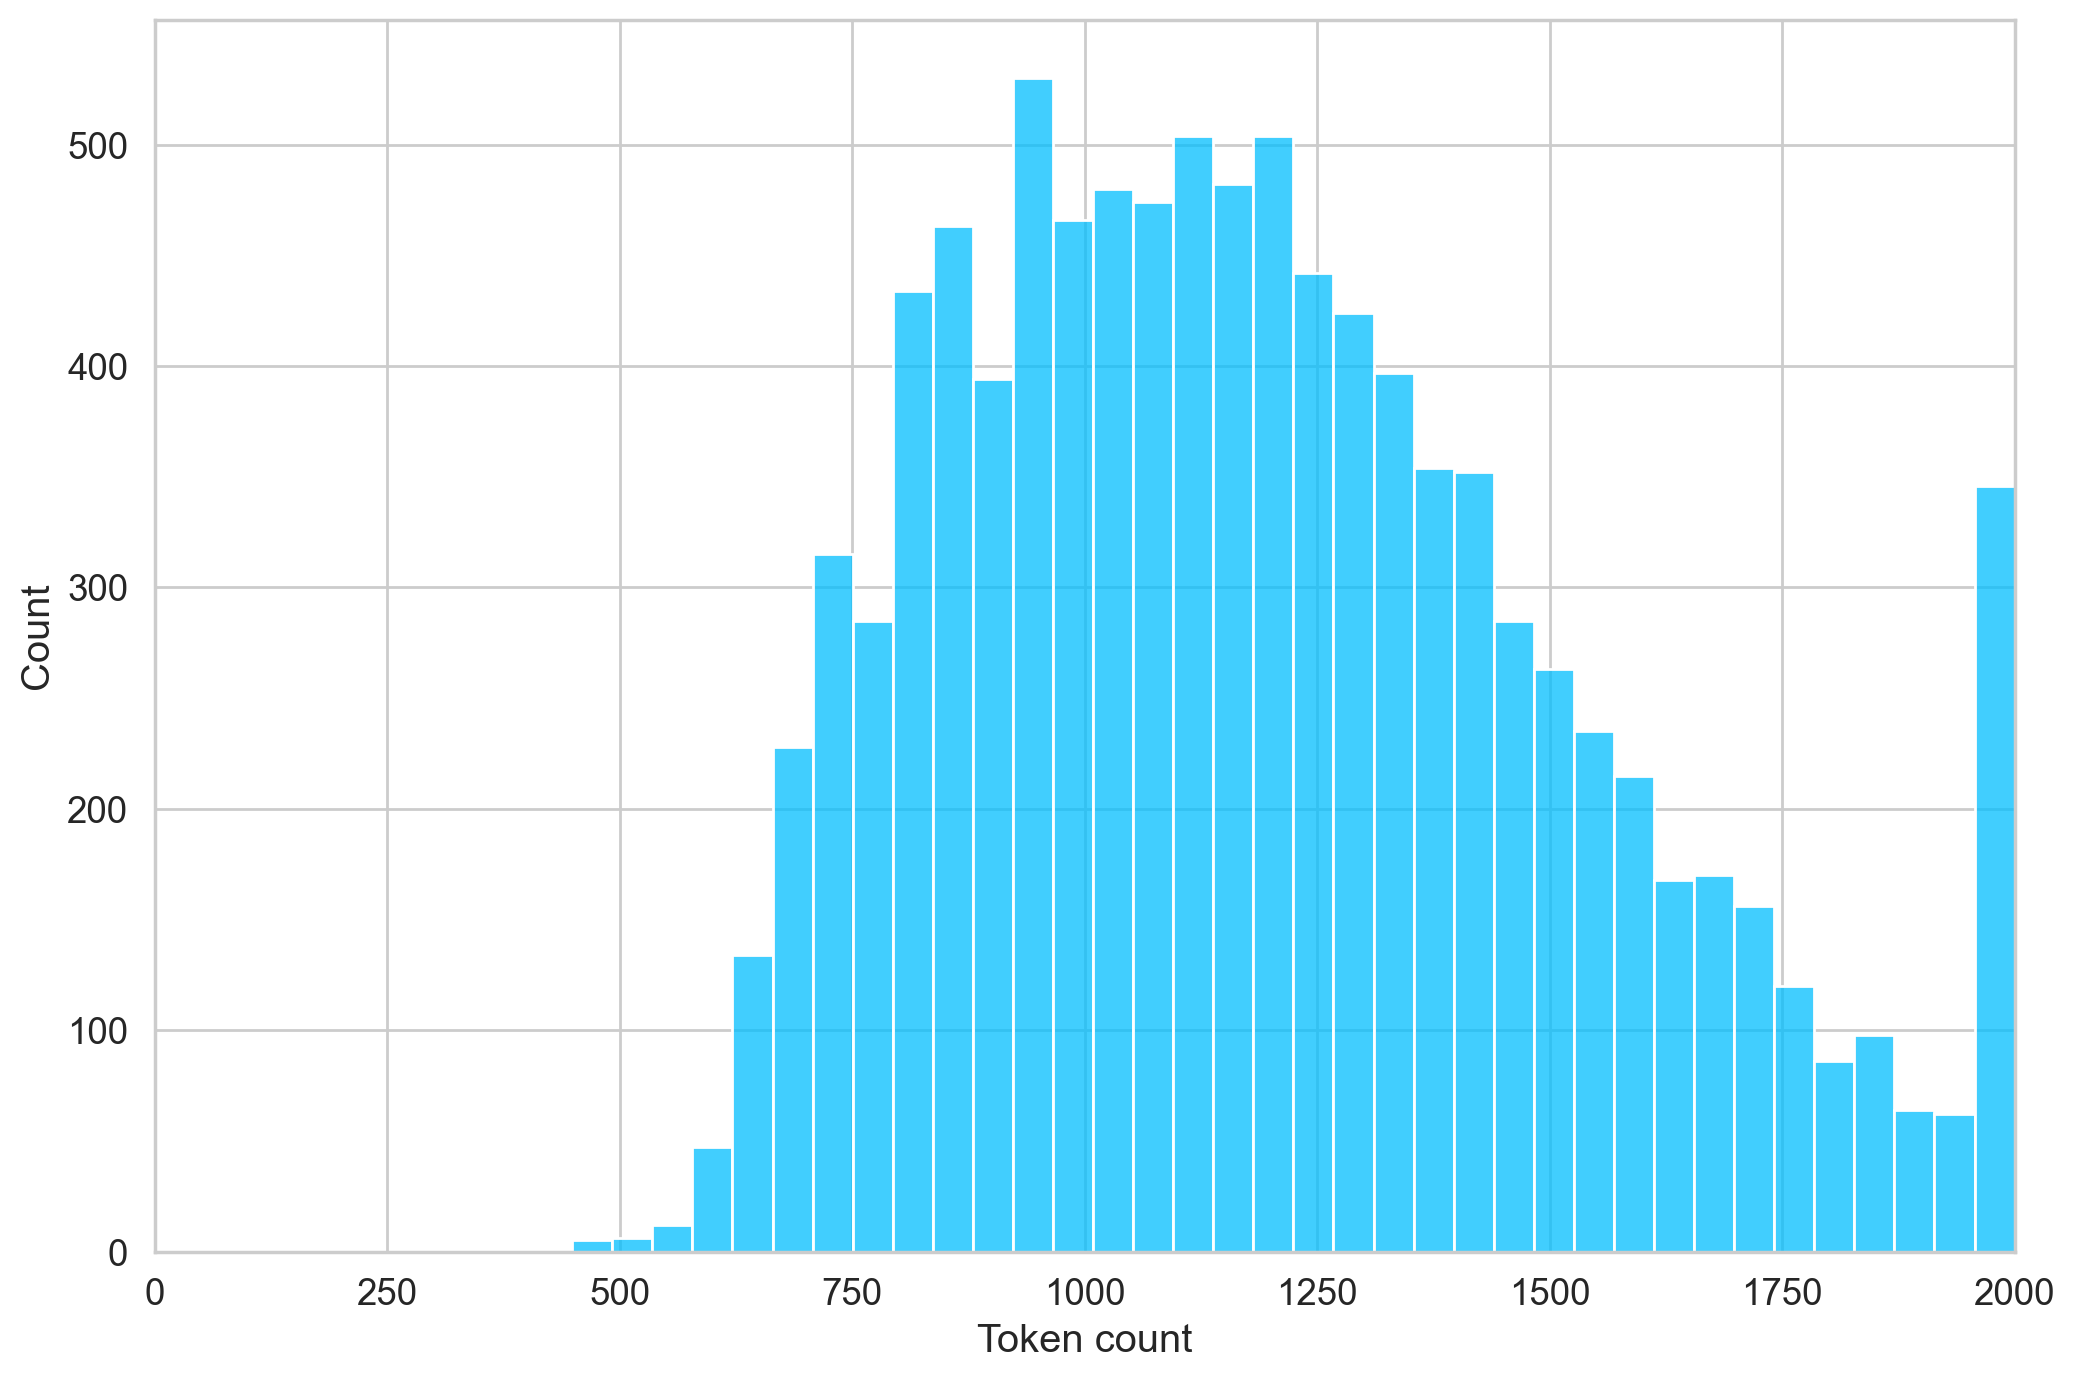

In [7]:
sns.histplot(token_lens)
plt.xlim([0, 2000]);
plt.xlabel('Token count');

## 3. 创建数据迭代器

In [8]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,  #使用 longformer 可以支持到4096tokens
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

按照9：1的比例划分训练集和测试集（验证集）  
> 因为没怎么调参，直接用的官方推荐参数，所以就没有划分验证集和测试集。

In [9]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

print(df_train.shape, df_test.shape)

(9000, 3) (1000, 3)


In [10]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.review.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [11]:
MAX_LEN = 2000 
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## 4. 使用Bert模型进行训练

In [12]:
# 解决权重无用警告
from transformers import logging
logging.set_verbosity_error()
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.longformer = LongformerModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.longformer.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.longformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(output['pooler_output'])
        return self.out(output)

In [14]:
model = SentimentClassifier(n_classes=25)
model = model.to(device)

EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:
def train_epoch(
        model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)


In [16]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)


In [17]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    start = time.time()
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc} time {time.time()-start}')
    test_acc, test_loss = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )
    print(f'TEST  loss {test_loss} accuracy {test_acc} time {time.time()-start}')
    print()

Epoch 1/5
----------



KeyboardInterrupt



这里的数据只有1w条，并且没有做数据清洗工作，但是对比之前实验3的结果反而还有所提升（之前验证集最好的结果为0.991），这足以说明 Bert 预训练模型的强大之处。